# This code can help you to find out the ways to print out ifmap, ofmap, weight and help you understand the process of QAT and PTQ quantization.
# However,  through verification, the ofmap calculated by the package is different from the equation  below, which is in the paper "Quantization and Training of Neural Networks for Efficient Integer-Arithmetic-Only Inference".
# The operation under the package is still unknown.
# If you are insterested in this code, maybe you can start from export PTQ.onnx file to Netron and try to understand the details of each block.
# You can also discuss with us on discord or share what you figure out in your report.
# Also, if you want to modify the code to do some experiment and answer report question 3 is perfectly fine.

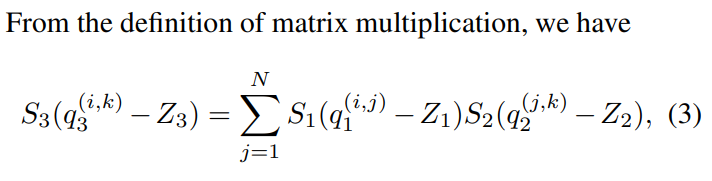

# **pre-processing**

**device**

In [1]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
no_cuda = False
use_gpu = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print(device)

cuda


**training, validation, test dataset**

In [2]:
batch_size = 16

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set_size = int(len(trainset) * 0.8)
valid_set_size = len(trainset) - train_set_size
train_set, val_set = torch.utils.data.random_split(trainset, [ train_set_size , valid_set_size ])
train_loader = torch.utils.data.DataLoader( train_set, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=2)
val_loader = torch.utils.data.DataLoader( val_set, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

print('Train: {}\nVal: {}\nTest: {}'.format(len(train_set), len(val_set), len(test_set)))

100%|██████████| 170498071/170498071 [00:03<00:00, 47828714.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train: 40000
Val: 10000
Test: 10000


**model**

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #stack 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        #stack 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        #stack 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        #stack 4
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        #stack 5
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.softmax = nn.Softmax(dim=1)

        self.classifier2 = nn.Linear(512 * 1 * 1, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv8(x)
        x = self.relu(x)
        x = self.conv9(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv11(x)
        x = self.relu(x)
        x = self.conv12(x)
        x = self.relu(x)
        x = self.conv13(x)
        x = self.relu(x)
        x = self.pool(x)

        #x = torch.flatten(x, 1)
        x = x.reshape(x.size(0), -1)
        x = self.classifier2(x)
        #x = self.softmax(x)
        return x

model_to_quantize = Net().to(device)

**1.   floating point model size 60.62MB**



In [4]:
!pip install torchsummary
from torchsummary import summary

summary(model_to_quantize,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

**pre-training**

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
LR = 0.01
n_epoch = 1
optimizer = optim.SGD(model_to_quantize.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)


train_loss = []
train_accu = []
total_train = 0
correct_train = 0

train_loss_compare=[]
train_accu_compare=[]
val_loss = []
val_accu = []
total_val = 0
correct_val = 0
for epoch in range(n_epoch):  # loop over the dataset multiple times]
    running_loss_train = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad() #reset gradient
        # forward + backward + optimize
        # compute gradient and do SGD steps
        outputs = model_to_quantize(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step() #更新權重
        #將data傳入model進行forward propagation
        #計算loss
        #清空前一次的gradient
        #根據loss進行back propagation，計算gradient
        #做gradient descent
        _, predicted = torch.max(outputs.data, 1) #不加_returen數值,加return位置
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        accu = 100.*correct_train/total_train
        # print statistics
        running_loss_train += loss.item()
        if ( (i >= 1875) and (i <= 2500) ):
            train_accu_compare.append(accu)
            train_loss_compare.append(loss.item())
        #print("count %d" %(i) )
        if i % 100 ==99:   # print every 100 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] Training loss: {running_loss_train / 100:.3f}')
            #print(f'Correct train: {correct_train} Total train: {total_train} Train accu: {accu} ')
            train_loss.append(loss.item())
            train_accu.append(accu)
            running_loss_train = 0.0
            total_train = 0
            correct_train = 0
        i += 1

    running_loss_val = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        outputs = model_to_quantize(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

        _, predicted = torch.max(outputs.data, 1) #不加_returen數值,加return位置
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
        accu = 100.*correct_val/total_val
        # print statistics
        running_loss_val += loss.item()
        val_accu.append(accu)
        #print("count %d" %(i) )
        if i % 100 ==99:   # print every 100 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] validation loss: {running_loss_val / 100:.3f}')
            #print(f'Correct validation: {correct_val} Total validation: {total_val} validation accu: {accu} ')
            running_loss_val = 0.0
            total_val = 0
            correct_val = 0
        i += 1

print('Finished ')

Finished 


## **quantization**

In [6]:
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization import QConfigMapping

In [7]:
# set different quantization config
qconfig = get_default_qconfig('qnnpack')
""" (below is example of different configuration)
qconfig = get_default_qconfig("fbgemm")
qconfig = torch.ao.quantization.default_qconfig
qconfig = torch.ao.quantization.qconfig.QConfig(
    activation=torch.ao.quantization.observer.HistogramObserver.with_args(
        qscheme=torch.per_tensor_symmetric,
        dtype=torch.qint8,
    ),
    weight=torch.ao.quantization.observer.PerChannelMinMaxObserver.with_args(
        #ch_axis=1,
        qscheme=torch.per_channel_symmetric,
        dtype=torch.qint8,
        ))
"""
qconfig_mapping = QConfigMapping().set_global(qconfig)

In [8]:
example_inputs = (next(iter(train_loader))[0]) #to know model input data type
prepared_model = prepare_fx(model_to_quantize, qconfig_mapping, example_inputs) # prepare to quantize model (fuse module (ex:CONV+BN+RELU...)，insert observer)

## **PTQ : do calibration**

In [9]:
def calibrate(model, device, data_loader):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device) #device
            model(data)
calibrate(prepared_model, 'cpu', test_loader)  # run calibration on sample data

In [10]:
quantized_model = convert_fx(prepared_model)

In [11]:
!pip install onnx
import torchvision.models as models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 48.3 MB/s eta 0:00:00


In [12]:
data = torch.randn(1, 3, 32, 32)
data.to(device)
torch.onnx.export(
    model_to_quantize,
    data,
    'float_model.onnx',
    export_params=True,
    opset_version=19,
)

torch.onnx.export(
    quantized_model,
    data,
    'PTQ_model.onnx',
    export_params=True,
    opset_version=19,
)

/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:1531: OnnxExporterWarning: Exporting to ONNX opset version 19 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 17. To use a newer opset version, consider 'torch.onnx.dynamo_export()'. Note that dynamo_export() is in preview. Please report errors with dynamo_export() as Github issues to https://github.com/pytorch/pytorch/issues.
  warnings.warn(


**print out each node name**

In [13]:
import torch
from torchvision.models import vgg16_bn
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

train_nodes, eval_nodes = get_graph_node_names(quantized_model)
print(train_nodes)

['x', 'quantize_per_tensor', 'conv1', 'conv2', 'pool', 'conv3', 'conv4', 'pool_1', 'conv5', 'conv6', 'conv7', 'pool_2', 'conv8', 'conv9', 'conv10', 'pool_3', 'conv11', 'conv12', 'conv13', 'pool_4', 'size', 'reshape', 'classifier2', 'dequantize']


/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


**put test image[0] into PTQ quant model**


In [14]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(test_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels[0])

#torch.set_printoptions(profile='full')

torch.Size([1, 3, 32, 32])
tensor(3)


In [15]:
input_image = images[0].unsqueeze(0)
print(input_image.shape)
output = quantized_model(input_image)

torch.Size([1, 3, 32, 32])


**use create feature extractor or hook to print out first layer ofmap**

In [16]:
features = []
def hook(module, input, output):
    features.append(output.clone().detach())
model2 = create_feature_extractor(quantized_model, ["conv1"])
handle = model2.conv1.register_forward_hook(hook)
output = quantized_model(input_image)
print(features[0][0].int_repr()) #[batch][channel][row][column]
print(features[0].shape)


tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0, 14, 11,  ...,  7,  9,  5]],

        [[ 0,  0,  0,  ...,  0,  0, 20],
         [ 0,  0,  0,  ...,  0,  0, 18],
         [ 0,  0,  0,  ...,  0,  0, 19],
         ...,
         [81, 66, 50,  ..., 65, 46,  0],
         [68, 66, 52,  ..., 63, 50,  0],
         [63, 50, 45,  ..., 52, 31,  3]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [10,  0,  0,  ...,  0,  0,  0],
         [14,  0,  0,  ...,  0,  0,  0],
         [ 1,  0,  0,  ...,  0,  0,  0]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0, 10],
         [ 0,  0,  1,  ...,  7, 10, 13],
         [ 0,  0,  0,  ...,  8,  9, 15],
         ...,
         [16, 17, 21,  ..., 14, 23, 21],
         [20, 11, 20, 

In [17]:
print(quantized_model)

GraphModule(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.005269043147563934, zero_point=0, padding=(1, 1))
  (conv2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.001722783432342112, zero_point=0, padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.000698996998835355, zero_point=0, padding=(1, 1))
  (conv4): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.00029162937426008284, zero_point=0, padding=(1, 1))
  (conv5): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.0001658321125432849, zero_point=0, padding=(1, 1))
  (conv6): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.0001236225652974099, zero_point=0, padding=(1, 1))
  (conv7): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.0001097360072890

**print bias, weight & weight scale & weight zero point , ifmap scale**

In [18]:
print(quantized_model.conv1.bias()[0])
print(quantized_model.conv1.weight()[0]) #print kernel 0
print(quantized_model.conv1.scale) #conv1 ifmap scale

tensor(-0.1345)
tensor([[[-0.0653, -0.0040, -0.0613],
         [-0.1212, -0.0013,  0.0306],
         [ 0.0972,  0.1279, -0.0386]],

        [[-0.0440,  0.0266,  0.1172],
         [ 0.0067, -0.1199, -0.0506],
         [ 0.1425,  0.1678,  0.1066]],

        [[ 0.0373,  0.1412,  0.1279],
         [ 0.0666,  0.1452, -0.0799],
         [ 0.0280, -0.0320, -0.0280]]], size=(3, 3, 3), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0013320236466825008,
       zero_point=0)
0.005269043147563934


In [30]:
array = [[[-0.0653, -0.0040, -0.0613],
         [-0.1212, -0.0013,  0.0306],
         [ 0.0972,  0.1279, -0.0386]],

        [[-0.0440,  0.0266,  0.1172],
         [ 0.0067, -0.1199, -0.0506],
         [ 0.1425,  0.1678,  0.1066]],

        [[ 0.0373,  0.1412,  0.1279],
         [ 0.0666,  0.1452, -0.0799],
         [ 0.0280, -0.0320, -0.0280]]]
tensor = torch.tensor(array)
print(tensor)

tensor([[[-0.0653, -0.0040, -0.0613],
         [-0.1212, -0.0013,  0.0306],
         [ 0.0972,  0.1279, -0.0386]],

        [[-0.0440,  0.0266,  0.1172],
         [ 0.0067, -0.1199, -0.0506],
         [ 0.1425,  0.1678,  0.1066]],

        [[ 0.0373,  0.1412,  0.1279],
         [ 0.0666,  0.1452, -0.0799],
         [ 0.0280, -0.0320, -0.0280]]])


In [31]:
kernel0_quant = torch.quantize_per_tensor(tensor, scale = 0.0013320236466825008, zero_point = 0, dtype=torch.qint8).int_repr()
print(kernel0_quant)

tensor([[[-49,  -3, -46],
         [-91,  -1,  23],
         [ 73,  96, -29]],

        [[-33,  20,  88],
         [  5, -90, -38],
         [107, 126,  80]],

        [[ 28, 106,  96],
         [ 50, 109, -60],
         [ 21, -24, -21]]], dtype=torch.int8)


**use create feature extractor or hook to print out calibrated image data and first layer ofmap**


**do image padding**

In [21]:
model_ofmap = create_feature_extractor(quantized_model, ["quantize_per_tensor"])
ofmap = model_ofmap(images)
input_layer = ofmap['quantize_per_tensor'].int_repr().numpy()
print(input_layer.shape)

(batch, channel, row, col) = input_layer.shape
new_row = 2*1 + row
new_col = 2*1 + col
#image = image.astype("float16")
#print(format)
input_layer_pad = np.zeros((batch,channel,new_row,new_col))
for i in range(0,new_row):
    for j in range(0,new_col):
        if( i>= 1 and i<=(new_row-1-1) and j>= 1 and j<=(new_col-1-1)):
            input_layer_pad[:,:,i,j] = input_layer[:,:,(i-1),(j-1)]
            input_layer_pad[:,:,i,j] = input_layer_pad[:,:,i,j] - 128
        else:
            input_layer_pad[:,:,i,j] = 0
print(input_layer_pad)

(1, 3, 32, 32)
[[[[   0.    0.    0. ...    0.    0.    0.]
   [   0.   31.   32. ...   -2.  -12.    0.]
   [   0.   25.   24. ...   -3.   -9.    0.]
   ...
   [   0.  -67.  -79. ...  -99. -108.    0.]
   [   0.  -74.  -72. ...  -94. -107.    0.]
   [   0.    0.    0. ...    0.    0.    0.]]

  [[   0.    0.    0. ...    0.    0.    0.]
   [   0.  -16.  -17. ...  -37.  -43.    0.]
   [   0.  -16.  -18. ...  -37.  -40.    0.]
   ...
   [   0.  -12.  -26. ...  -46.  -64.    0.]
   [   0.  -21.  -23. ...  -44.  -61.    0.]
   [   0.    0.    0. ...    0.    0.    0.]]

  [[   0.    0.    0. ...    0.    0.    0.]
   [   0.  -79.  -81. ...  -92.  -95.    0.]
   [   0.  -77.  -88. ...  -96.  -94.    0.]
   ...
   [   0.   41.   21. ...   -2.  -21.    0.]
   [   0.   33.   22. ...    2.  -18.    0.]
   [   0.    0.    0. ...    0.    0.    0.]]]]


**turn to numpy if you need to compute the data**

In [22]:
model_ofmap = create_feature_extractor(quantized_model, ["conv1"])
ofmap = model_ofmap(images)
conv1_layer = ofmap['conv1'].int_repr().numpy()
print(conv1_layer.shape)

(1, 64, 32, 32)


**2. PTQ model size 14.750436 MB**

In [23]:
import os
torch.save(quantized_model.state_dict(), "PTQ_model.p")
print('Size of the int8 model(MB):', os.path.getsize("PTQ_model.p")/1e6)

Size of the int8 model(MB): 14.750436


# **QAT : Do Training**

In [24]:
model_to_quantize.train()
prepared_model_QAT = prepare_fx(model_to_quantize, qconfig_mapping, example_inputs) # prepare to quantize model (fuse module (ex:CONV+BN+RELU...)，insert observer)
prepared_model_QAT.to(device)

GraphModule(
  (activation_post_process_0): HistogramObserver(min_val=inf, max_val=-inf)
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (activation_post_process_1): HistogramObserver(min_val=inf, max_val=-inf)
  (conv2): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (activation_post_process_2): HistogramObserver(min_val=inf, max_val=-inf)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation_post_process_3): HistogramObserver(min_val=inf, max_val=-inf)
  (conv3): ConvReLU2d(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (activation_post_process_4): HistogramObserver(min_val=inf, max_val=-inf)
  (conv4): ConvReLU2d(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (activation_post_process_5): HistogramObserver

In [25]:
criterion = nn.CrossEntropyLoss()
LR = 0.01
n_epoch_QAT = 1
optimizer = optim.SGD(model_to_quantize.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

train_loss = []
train_accu = []
total_train = 0
correct_train = 0

train_loss_compare=[]
train_accu_compare=[]
val_loss = []
val_accu = []
total_val = 0
correct_val = 0
for epoch in range(n_epoch_QAT):  # loop over the dataset multiple times]
    running_loss_train = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
            #print("gpu")
        # zero the parameter gradients
        optimizer.zero_grad() #reset gradient
        # forward + backward + optimize
        # compute gradient and do SGD steps
        outputs = prepared_model_QAT(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step() #更新權重
        #將data傳入model進行forward propagation
        #計算loss
        #清空前一次的gradient
        #根據loss進行back propagation，計算gradient
        #做gradient descent
        _, predicted = torch.max(outputs.data, 1) #不加_returen數值,加return位置
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        accu = 100.*correct_train/total_train
        # print statistics
        running_loss_train += loss.item()
        if ( (i >= 1875) and (i <= 2500) ):
            train_accu_compare.append(accu)
            train_loss_compare.append(loss.item())
        #print("count %d" %(i) )
        if i % 100 ==99:   # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] Training loss: {running_loss_train / 100:.3f}')
            print(f'Correct train: {correct_train} Total train: {total_train} Train accu: {accu} ')
            train_loss.append(loss.item())
            train_accu.append(accu)
            running_loss_train = 0.0
            total_train = 0
            correct_train = 0
        i += 1

    running_loss_val = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        outputs = prepared_model_QAT(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

        _, predicted = torch.max(outputs.data, 1) #不加_returen數值,加return位置
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
        accu = 100.*correct_val/total_val
        # print statistics
        running_loss_val += loss.item()
        val_accu.append(accu)
        #print("count %d" %(i) )
        if i % 100 ==99:   # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] validation loss: {running_loss_val / 100:.3f}')
            print(f'Correct validation: {correct_val} Total validation: {total_val} validation accu: {accu} ')
            running_loss_val = 0.0
            total_val = 0
            correct_val = 0
        i += 1

print('Finished ')

[1,   100] Training loss: 2.304
Correct train: 171 Total train: 1600 Train accu: 10.6875 
[1,   200] Training loss: 2.305
Correct train: 158 Total train: 1600 Train accu: 9.875 
[1,   300] Training loss: 2.304
Correct train: 170 Total train: 1600 Train accu: 10.625 
[1,   400] Training loss: 2.303
Correct train: 148 Total train: 1600 Train accu: 9.25 
[1,   500] Training loss: 2.302
Correct train: 171 Total train: 1600 Train accu: 10.6875 
[1,   600] Training loss: 2.305
Correct train: 151 Total train: 1600 Train accu: 9.4375 
[1,   700] Training loss: 2.305
Correct train: 149 Total train: 1600 Train accu: 9.3125 
[1,   800] Training loss: 2.305
Correct train: 149 Total train: 1600 Train accu: 9.3125 
[1,   900] Training loss: 2.306
Correct train: 144 Total train: 1600 Train accu: 9.0 
[1,  1000] Training loss: 2.304
Correct train: 152 Total train: 1600 Train accu: 9.5 
[1,  1100] Training loss: 2.305
Correct train: 162 Total train: 1600 Train accu: 10.125 
[1,  1200] Training loss: 2.

In [26]:
prepared_model_QAT.eval()

GraphModule(
  (activation_post_process_0): HistogramObserver(min_val=-1.0, max_val=1.0)
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (activation_post_process_1): HistogramObserver(min_val=0.0, max_val=1.5611714124679565)
  (conv2): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (activation_post_process_2): HistogramObserver(min_val=0.0, max_val=0.6222428679466248)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation_post_process_3): HistogramObserver(min_val=0.0, max_val=0.6222428679466248)
  (conv3): ConvReLU2d(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (activation_post_process_4): HistogramObserver(min_val=0.0, max_val=0.22827841341495514)
  (conv4): ConvReLU2d(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Re

In [27]:
QAT_model = convert_fx(prepared_model_QAT) # convert the calibrated model to a quantized model

In [28]:
print(QAT_model)

GraphModule(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.005034108646214008, zero_point=0, padding=(1, 1))
  (conv2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0015834880759939551, zero_point=0, padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.0006154565489850938, zero_point=0, padding=(1, 1))
  (conv4): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.0002648263762239367, zero_point=0, padding=(1, 1))
  (conv5): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.00014976027887314558, zero_point=0, padding=(1, 1))
  (conv6): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.00011704178177751601, zero_point=0, padding=(1, 1))
  (conv7): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.0001057949630

**3. QAT model size 14.751396 MB**

In [29]:
import os
torch.save(QAT_model.state_dict(), "QAT_model.p")
print('Size of the int8 model(MB):', os.path.getsize("QAT_model.p")/1e6)

Size of the int8 model(MB): 14.751396
